<a href="https://colab.research.google.com/github/aatika-hakim/AI/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install langgraph langchain_google_genai langchain_community langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.0 MB/s eta 0:00:00


In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [10]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [11]:
graph_builder = StateGraph(State)

In [12]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
# llm.invoke("hi").content
from google.colab import userdata

api_key = userdata.get('GROQ_API_KEY')

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=1, api_key= api_key)
llm.invoke("hi").content

"How's it going? Is there something I can help you with or would you like to chat?"

In [13]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

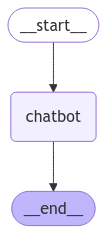

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: how to make biryani?
User: What do you know about LangGraph?
Assistant: LangGraph is an open-source, multilingual large language model developed by the LangGraph team. It's designed to process and generate human-like language, similar to other popular language models like BERT, RoBERTa, and others.

Here are some key features of LangGraph:

1. **Multilingual support**: LangGraph is trained on a massive dataset that covers many languages, making it a versatile model for various natural language processing (NLP) tasks across languages.
2. **Large-scale training**: The model is trained on a large corpus of text data, which enables it to learn complex patterns and relationships in language.
3. **Open-source**: LangGraph is open-source, which means that developers and researchers can access, modify, and distribute the model, promoting collaboration and innovation in the NLP community.
4. **Customizable**: The LangGraph model can be fine-tuned for specific NLP tasks, such as language t

In [16]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [17]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: q
Goodbye!


In [ ]:
from google.colab import userdata
import os

os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')

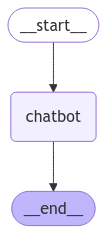

User: how to make biryani
Error: 'HumanMessage' object is not subscriptable


In [18]:
!pip install langgraph langchain_google_genai langchain_community

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from google.colab import userdata

# Define the state structure
class State(TypedDict):
    messages: Annotated[list, add_messages]  # Tracks conversation messages
    short_term_memory: dict  # Short-term memory for session

# Initialize LangGraph
graph_builder = StateGraph(State)

# Set up the LLM
api_key = userdata.get("GROQ_API_KEY")
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=1, api_key=api_key)

# Tool: Recipe Retriever (Mock Implementation)
def retrieve_recipe(tool_input: str) -> str:
    recipes = {
        "pasta": "Boil water, add pasta, cook for 10 mins. Add sauce and serve.",
        "pancakes": "Mix flour, milk, eggs. Pour on skillet. Flip when bubbles appear.",
    }
    return recipes.get(tool_input.lower(), "Recipe not found. Please try another dish.")

# Human-in-the-Loop (Mock)
def human_approval(response: str) -> str:
    print("Human approval required!")
    print(f"Response: {response}")
    user_decision = input("Approve this response? (yes/no): ").strip().lower()
    return response if user_decision == "yes" else "The response has been modified for clarity."

# Chatbot function with memory
def chatbot(state: State):
    user_message = state["messages"][-1]["content"].lower()
    memory = state["short_term_memory"]

    if "recipe" in user_message:
        # Extract dish name and get recipe
        dish = user_message.replace("recipe", "").strip()
        if dish in memory:  # Check short-term memory
            return {
                "messages": [
                    {
                        "role": "assistant",
                        "content": f"Here's the recipe for {dish} from memory: {memory[dish]}",
                    }
                ]
            }

        # Retrieve new recipe
        tool_response = retrieve_recipe(dish)
        final_response = human_approval(tool_response)

        # Update short-term memory
        memory[dish] = final_response
        return {"messages": [{"role": "assistant", "content": final_response}]}

    # Default fallback response
    return {"messages": [{"role": "assistant", "content": "I'm here to share recipes. Please ask about a dish!"}]}

# Add nodes and transitions
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Add visualization for the full graph
graph = graph_builder.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# Interactive session
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}], "short_term_memory": {}}):
        for value in event.values():
            print("Assistant:", value["messages"][-1]["content"])

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except Exception as e:
        print(f"Error: {e}")
        break


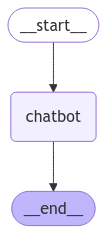

In [ ]:
!pip install langgraph requests

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import requests

API_URL = "https://www.themealdb.com/api/json/v1/1/"

# Define the state structure
class State(TypedDict):
    messages: Annotated[list, add_messages]
    short_term_memory: dict

# Initialize LangGraph
graph_builder = StateGraph(State)

# API Helper Functions
def search_meal_by_name(name: str) -> str:
    response = requests.get(f"{API_URL}search.php?s={name}")
    data = response.json()
    if data["meals"]:
        meal = data["meals"][0]
        return f"{meal['strMeal']} - {meal['strInstructions']} (Link: {meal['strSource']})"
    return "No meal found with that name."

def list_meals_by_letter(letter: str) -> str:
    response = requests.get(f"{API_URL}search.php?f={letter}")
    data = response.json()
    if data["meals"]:
        return "\n".join([meal["strMeal"] for meal in data["meals"]])
    return f"No meals found starting with the letter '{letter}'."

def lookup_meal_by_id(meal_id: str) -> str:
    response = requests.get(f"{API_URL}lookup.php?i={meal_id}")
    data = response.json()
    if data["meals"]:
        meal = data["meals"][0]
        return f"{meal['strMeal']} - {meal['strInstructions']} (Link: {meal['strSource']})"
    return "No meal found with that ID."

def random_meal() -> str:
    response = requests.get(f"{API_URL}random.php")
    data = response.json()
    if data["meals"]:
        meal = data["meals"][0]
        return f"{meal['strMeal']} - {meal['strInstructions']} (Link: {meal['strSource']})"
    return "Could not fetch a random meal."

def list_categories() -> str:
    response = requests.get(f"{API_URL}categories.php")
    data = response.json()
    if data["categories"]:
        return "\n".join([category["strCategory"] for category in data["categories"]])
    return "No categories available."

# Define Graph Nodes
def chatbot(state: State):
    user_message = state["messages"][-1]["content"].lower()
    memory = state["short_term_memory"]

    if "search meal by name" in user_message:
        meal_name = user_message.replace("search meal by name", "").strip()
        response = search_meal_by_name(meal_name)
        return {"messages": [{"role": "assistant", "content": response}]}

    elif "list meals by letter" in user_message:
        letter = user_message.replace("list meals by letter", "").strip()
        response = list_meals_by_letter(letter)
        return {"messages": [{"role": "assistant", "content": response}]}

    elif "lookup meal by id" in user_message:
        meal_id = user_message.replace("lookup meal by id", "").strip()
        response = lookup_meal_by_id(meal_id)
        return {"messages": [{"role": "assistant", "content": response}]}

    elif "random meal" in user_message:
        response = random_meal()
        return {"messages": [{"role": "assistant", "content": response}]}

    elif "list categories" in user_message:
        response = list_categories()
        return {"messages": [{"role": "assistant", "content": response}]}

    else:
        return {"messages": [{"role": "assistant", "content": "I didn't understand that. Try asking for a recipe or category!"}]}

# Build Graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile and visualize the graph
graph = graph_builder.compile()

from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# Interactive Chat
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}], "short_term_memory": {}}):
        for value in event.values():
            print("Assistant:", value["messages"][-1]["content"])

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except Exception as e:
        print(f"Error: {e}")
        break
